

# Итоговое задание юнита 2
# Разведовательный анализ данных


In [1]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np

# 1. Предварительный анализ данных

In [2]:
stud = pd.read_csv('stud_math.csv') # Загружаем данные
stud.sample(5)                      # Просмотр 5 случайных образцов

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
68,GP,F,15,R,LE3,T,2.0,2.0,health,NaN,...,-6.0,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0
131,GP,F,15,U,GT3,NaN,1.0,1.0,at_home,other,...,-3.0,yes,yes,yes,4.0,NaN,3.0,4.0,0.0,0.0
80,GP,M,15,U,GT3,T,2.0,3.0,other,services,...,-3.0,yes,NaN,yes,3.0,2.0,2.0,3.0,2.0,60.0
386,MS,F,18,R,GT3,T,4.0,4.0,teacher,at_home,...,-3.0,yes,yes,yes,4.0,4.0,3.0,5.0,7.0,30.0
293,GP,F,17,R,LE3,T,3.0,1.0,services,other,...,-12.0,yes,no,NaN,3.0,1.0,2.0,3.0,6.0,90.0


In [3]:
stud.info() # Также полезно знать формат данных DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Из вышеуказанной информации видно, что:
* Hабор данных содержит информацию о 395 учениках по 30 признаков для каждого (17 - строка, 13 - числовой тип).
* *Очень странно! В исходных данных нет такого поля как 'studytime, granular'. Надо быть аккуратней с ним!*
* Только столбцы school, sex, age полностью заполнены, остальные содержат пропуски (максимум 45 для Pstatus (по мне как-то личная информация, наверное не все хотят делиться)).
* Необходимо будет решить, что делать с пропусками, и можно ли их заменить.

## Предобработка
Блок предназначен для реализации необходимых функций для анализа данных.

In [4]:
pd.set_option('display.max_columns', 30) # Показывать все столбцы в наборе
sns.set(style="darkgrid")                # Для глаза приятнее

# Создаём list с ограничениями по признакам
limits = [None,     # Ограничений на признак school не указано
          None,     # Ограничений на признак sex не указано
          (15, 22), # Ограничения на признак age указаны в постановке задачи
          None,     # Ограничений на признак address не указано
          None,     # Ограничений на признак famsize не указано
          None,     # Ограничений на признак Pstatus не указано
          (0, 4),   # Ограничения на признак Medu указаны в постановке задачи
          (0, 4),   # Ограничения на признак Fedu указаны в постановке задачи
          None,     # Ограничений на признак Mjob не указано
          None,     # Ограничений на признак Fjob не указано
          None,     # Ограничений на признак reason не указано
          None,     # Ограничений на признак guardian не указано
          (1, 4),   # Ограничения на признак traveltime указаны в постановке задачи
          (1, 4),   # Ограничения на признак studytime указаны в постановке задачи
          (0, 4),   # Ограничения на признак failures указаны в постановке задачи
          None,     # Ограничений на признак schoolsup не указано
          None,     # Ограничений на признак famsup не указано
          None,     # Ограничений на признак paid не указано
          None,     # Ограничений на признак activities не указано
          None,     # Ограничений на признак nursery не указано
          None,     # Ограничений на признак studytime, granular не указано
          None,     # Ограничений на признак higher не указано
          None,     # Ограничений на признак internet не указано
          None,     # Ограничений на признак romantic не указано
          (1, 5),   # Ограничения на признак famrel указаны в постановке задачи
          (1, 5),   # Ограничения на признак freetime указаны в постановке задачи
          (1, 5),   # Ограничения на признак goout указаны в постановке задачи
          (1, 5),   # Ограничения на признак health указаны в постановке задачи
          None,     # Ограничений на признак absences не указано
          (0, 100)] # Ограничений на признак score не указано*


def pre_analysis(column, limits):
    '''Функция, представляющая распределение признаков:
    - построение гистограммы, либо колонок
    - вычисление доли пропусков'''
    
    print('\nРаспределение признака', column) # Контрольная печать признака
    figure, axes = plt.subplots()             # Получаем Figure и Axes
    
    if stud.loc[:, column].dtypes == np.dtype('O'): # Если object, то это строка
        sns.countplot(stud.loc[:, column], ax=axes) # Подготавливаем колонки
        plt.show()                                  # Выводим на экран
    else: # Если числовые данные
        stud.loc[:, column].hist(ax=axes)        # Подготавливаем гистограмму
        axes.set_xlabel(column)                  # Подпись под осью Ox
        axes.set_ylabel('count')                 # Подпись под осью Oy
        plt.show()                               # Выводим на экран
        
        if limits is not None: # Если для признака есть пределы, то проводим анализ на выбросы
            out_index = (~(stud.loc[:, column].between(limits[0], limits[1]))&
                        pd.notnull(stud.loc[:, column]))
            if stud.loc[out_index].shape[0] > 0:
                print('Обнаружены выбросы:')
                display(stud.loc[out_index])
    print('Процент пропусков: ' + str(round(100 - stud.loc[:, column].count()/stud.shape[0]*100, 2)) + '%')
    print('####################################\n')
    
    
def nom_analysis(column):
    '''Функция построения боксплотов и 
    выявления статистически значимых различий'''

    if stud.loc[:, column].dtypes == np.dtype('O'):          # Если object, то это строка
        print('Распределение баллов по признаку:', column,)  # Контрольная печать признака
        figure, axes = plt.subplots(figsize = (14, 4))       # Получаем Figure и Axes
        sns.boxplot(x=column, y='score', data=stud, ax=axes) # Строим боксплот
        axes.set_title('Boxplot: ' + column)                 # Подпись к боксплоту
        plt.show()                                           # Выводим на экран
        
        # Создаём комбинации для теста Стьюдента
        combinations_all = list(combinations(stud.loc[:, column].dropna().unique(), 2))
        for combination in combinations_all:
            if ttest_ind(stud.loc[stud.loc[:, column] == combination[0], 'score'].dropna(), 
                            stud.loc[stud.loc[:, column] == combination[1], 'score'].dropna()).pvalue \
                <= 0.05/len(combinations_all): # Поправка Бонферони
                print('Найдены статистически значимые различия для колонки', column)
                break
        print('####################################\n')

\* Заметим, что последний элемент limits в первоначальной постановке задачи не задан, но руководствуясь здравым смыслом и информацией извне, ясно, что это значение от 0 до 100.

# 2. Анализ данных в столбцах
Выполним:
* Вычисление распределения признаков числовых столбцов, количество номинативных переменных;
* Построение графического представления информации;
* Работа с выбросами.


Распределение признака school


C:\Users\Alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


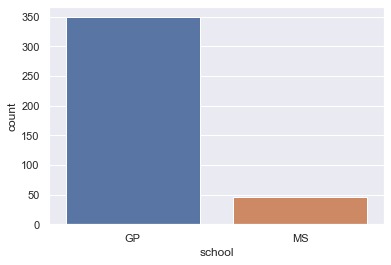

Процент пропусков: 0.0%
####################################


Распределение признака sex


C:\Users\Alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


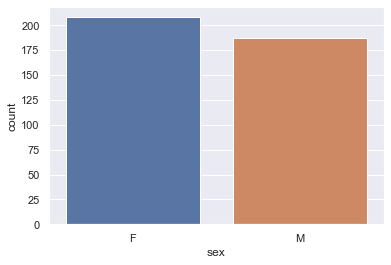

Процент пропусков: 0.0%
####################################


Распределение признака age


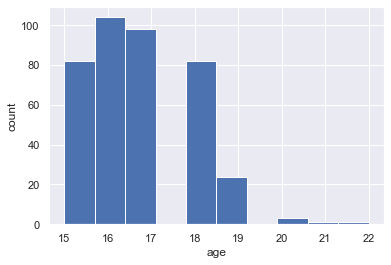

Процент пропусков: 0.0%
####################################


Распределение признака address


C:\Users\Alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


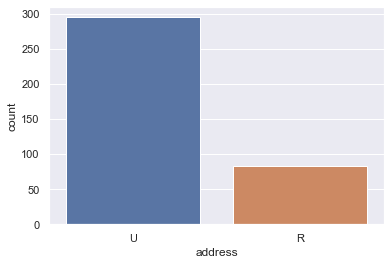

Процент пропусков: 4.3%
####################################


Распределение признака famsize


C:\Users\Alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


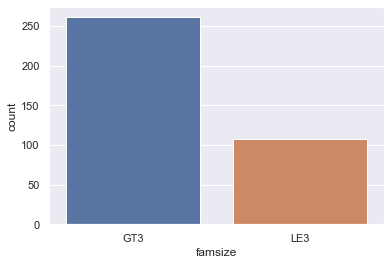

C:\Users\Alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Процент пропусков: 6.84%
####################################


Распределение признака Pstatus


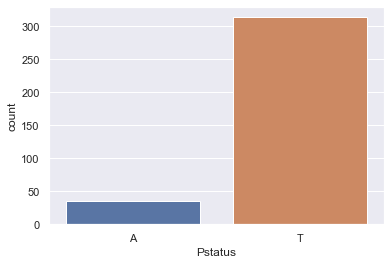

Процент пропусков: 11.39%
####################################


Распределение признака Medu


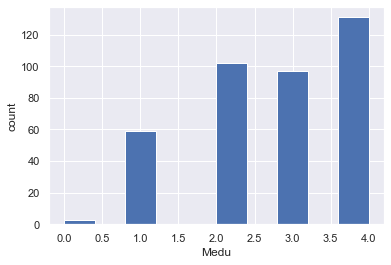

Процент пропусков: 0.76%
####################################


Распределение признака Fedu


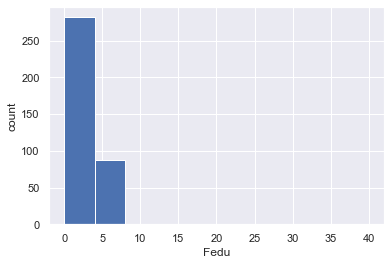

Обнаружены выбросы:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,U,GT3,NaN,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


Процент пропусков: 6.08%
####################################


Распределение признака Mjob


C:\Users\Alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


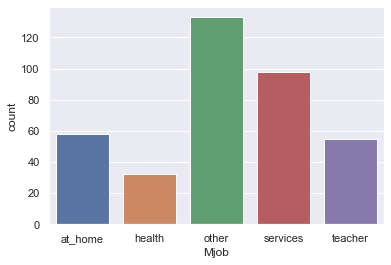

Процент пропусков: 4.81%
####################################


Распределение признака Fjob


C:\Users\Alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


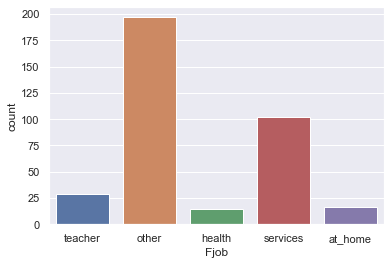

Процент пропусков: 9.11%
####################################


Распределение признака reason


C:\Users\Alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


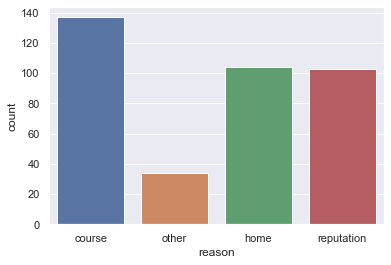

Процент пропусков: 4.3%
####################################


Распределение признака guardian


C:\Users\Alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


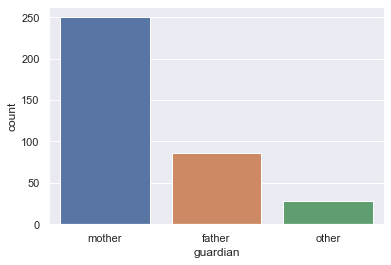

Процент пропусков: 7.85%
####################################


Распределение признака traveltime


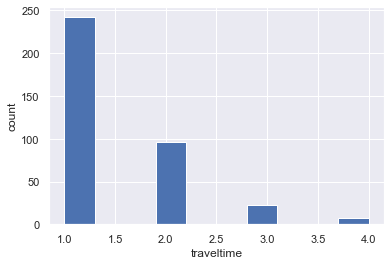

Процент пропусков: 7.09%
####################################


Распределение признака studytime


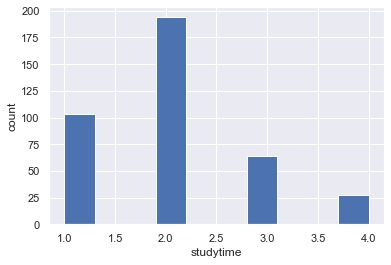

Процент пропусков: 1.77%
####################################


Распределение признака failures


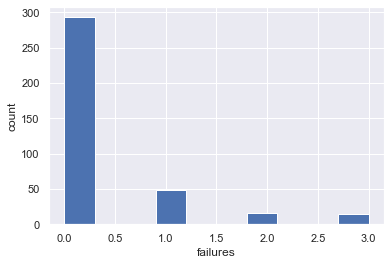

Процент пропусков: 5.57%
####################################


Распределение признака schoolsup


C:\Users\Alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


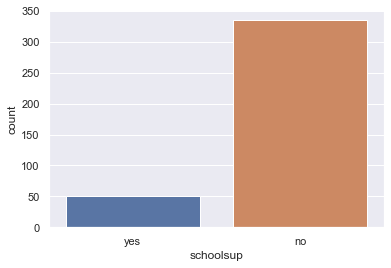

Процент пропусков: 2.28%
####################################


Распределение признака famsup


C:\Users\Alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


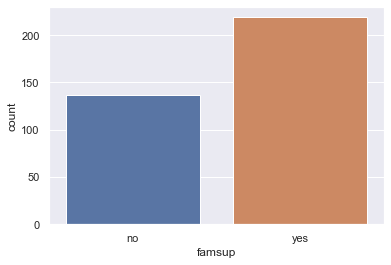

Процент пропусков: 9.87%
####################################


Распределение признака paid


C:\Users\Alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


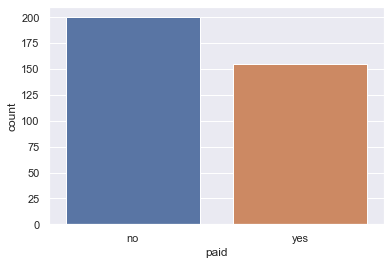

C:\Users\Alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Процент пропусков: 10.13%
####################################


Распределение признака activities


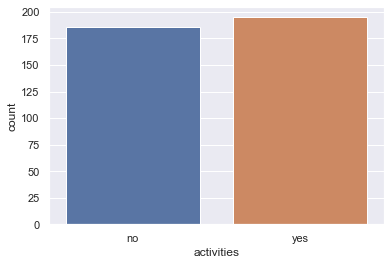

C:\Users\Alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Процент пропусков: 3.54%
####################################


Распределение признака nursery


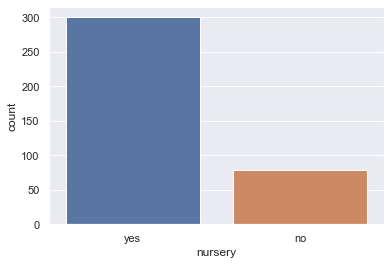

Процент пропусков: 4.05%
####################################


Распределение признака studytime, granular


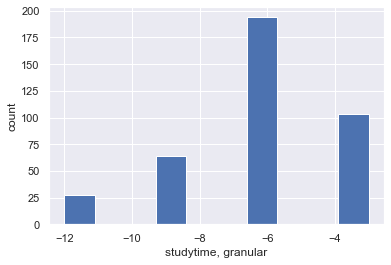

Процент пропусков: 1.77%
####################################


Распределение признака higher


C:\Users\Alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


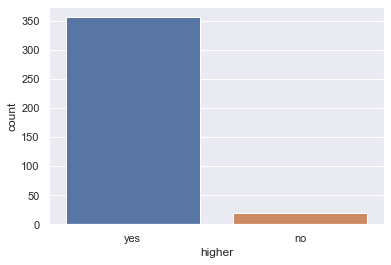

Процент пропусков: 5.06%
####################################


Распределение признака internet


C:\Users\Alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


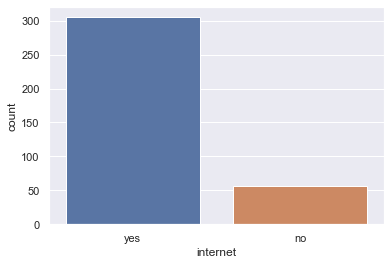

Процент пропусков: 8.61%
####################################


Распределение признака romantic


C:\Users\Alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


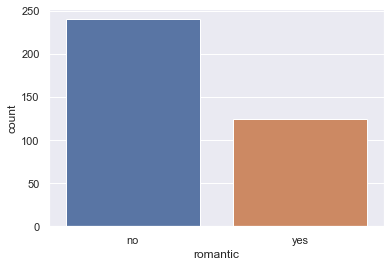

Процент пропусков: 7.85%
####################################


Распределение признака famrel


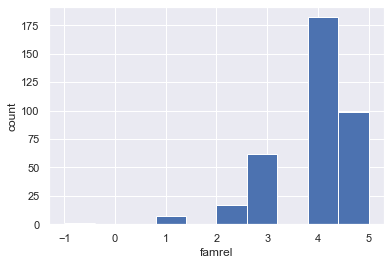

Обнаружены выбросы:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,-3.0,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0


Процент пропусков: 6.84%
####################################


Распределение признака freetime


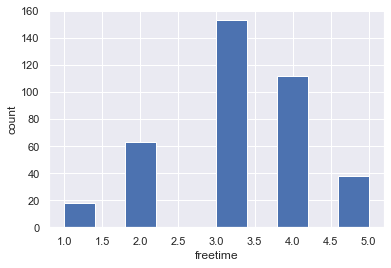

Процент пропусков: 2.78%
####################################


Распределение признака goout


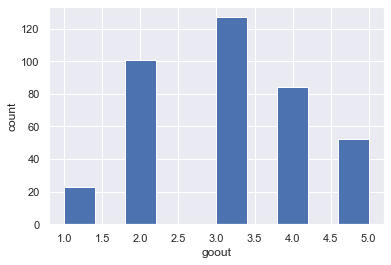

Процент пропусков: 2.03%
####################################


Распределение признака health


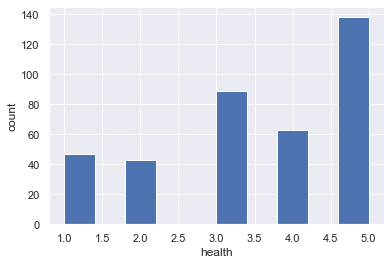

Процент пропусков: 3.8%
####################################


Распределение признака absences


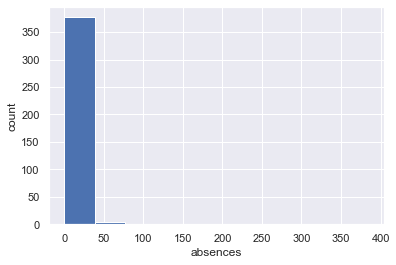

Процент пропусков: 3.04%
####################################


Распределение признака score


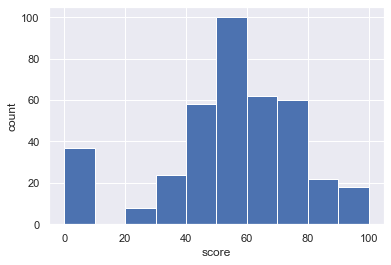

Процент пропусков: 1.52%
####################################



In [5]:
# В цикле выполняем вызов функции pre_analysis
for index in range(stud.columns.size):
    pre_analysis(stud.columns[index], limits[index])

На основе полученных данных можно сделать следующие выводы:
* Данные в столбцах вполне приемлимые;
* Очень странное распределение в столбце absences;
* В столбцах famrel и Fedu присустсвуют выбросы (по постановке задачи), поэтому я решил их удалить;
* Доля пропусков лежит в интервале от 1% до ~12%;
* Чем заполнить пропущенные значения не понятно пока.

Предлагаю разобраться со столбцом absences.

<AxesSubplot:>

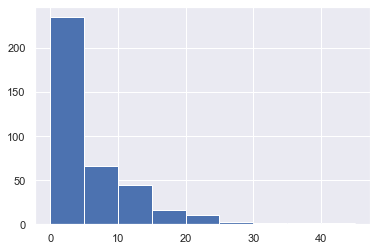

In [6]:
# Построим более подробную гистограмму
stud.loc[:, 'absences'].hist(bins=list(range(0,50,5)))

Очень странный результат
Воспользуемся методом определения выбросов на основе интерквартильного расстояния.

In [7]:
perc25 = stud.absences.quantile(0.25)
perc75 = stud.absences.quantile(0.75)
IQR = perc75 - perc25
print('25-й перцентиль: {},'.format(perc25))
print('27-й перцентиль: {},'.format(perc75),)
print('IQR:', IQR)

IQR = perc75 - perc25
stud.loc[~stud.absences.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR), 'absences']

25-й перцентиль: 0.0,
27-й перцентиль: 8.0,
IQR: 8.0


24       NaN
40      25.0
74      54.0
101      NaN
103     26.0
120      NaN
129      NaN
150      NaN
172      NaN
183     56.0
198     24.0
205     28.0
215      NaN
216     22.0
222    385.0
227      NaN
254      NaN
260     21.0
265      NaN
270      NaN
276     75.0
277     22.0
280     30.0
307     38.0
313     22.0
315     40.0
320     23.0
352      NaN
390    212.0
Name: absences, dtype: float64

В наборе присутствуют выбросы, которые сложно объяснить, так как, если принимать числа в этом столбце как дни, то у некоторых учеников количество пропущенных дней больше, чем дней в году. Если это уроки, то всё равно много. Будем считать, что это дни. Поэтому, в силу того, что люди могут болеть, а некотрые чаще, то будем считать, что максимальное количество пропущенных дней - 40. Остальные удаляем.
Я художник, я так вижу.. 


Распределение признака absences


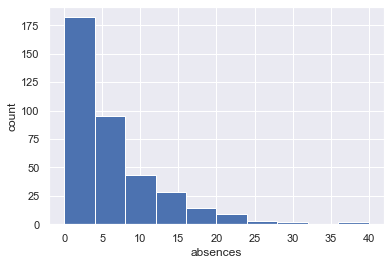

Процент пропусков: 3.08%
####################################



In [8]:
# Обновляем набор данных
stud = stud.loc[stud.absences.between(perc25 - 1.5*IQR, 40)|pd.isnull(stud.absences)]

# Визуализируем признак
pre_analysis('absences', None)

Распределение absences стало лучше.

Обработаем теперь выбросы.. Путём удаления..

In [9]:
# Удаляем строки соответствующие выбросам
stud = stud.loc[stud.Fedu.between(0,4)|pd.isnull(stud.Fedu)]
stud = stud.loc[stud.famrel.between(1,5)|pd.isnull(stud.famrel)]

Посмотрим, что получилось.

In [10]:
# Выводим информацию о наборе
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               388 non-null    object 
 1   sex                  388 non-null    object 
 2   age                  388 non-null    int64  
 3   address              371 non-null    object 
 4   famsize              361 non-null    object 
 5   Pstatus              346 non-null    object 
 6   Medu                 385 non-null    float64
 7   Fedu                 364 non-null    float64
 8   Mjob                 369 non-null    object 
 9   Fjob                 352 non-null    object 
 10  reason               371 non-null    object 
 11  guardian             358 non-null    object 
 12  traveltime           360 non-null    float64
 13  studytime            381 non-null    float64
 14  failures             366 non-null    float64
 15  schoolsup            379 non-null    obj

Ожидаемо набор стал меньше.

# 3. Корреляционный анализ

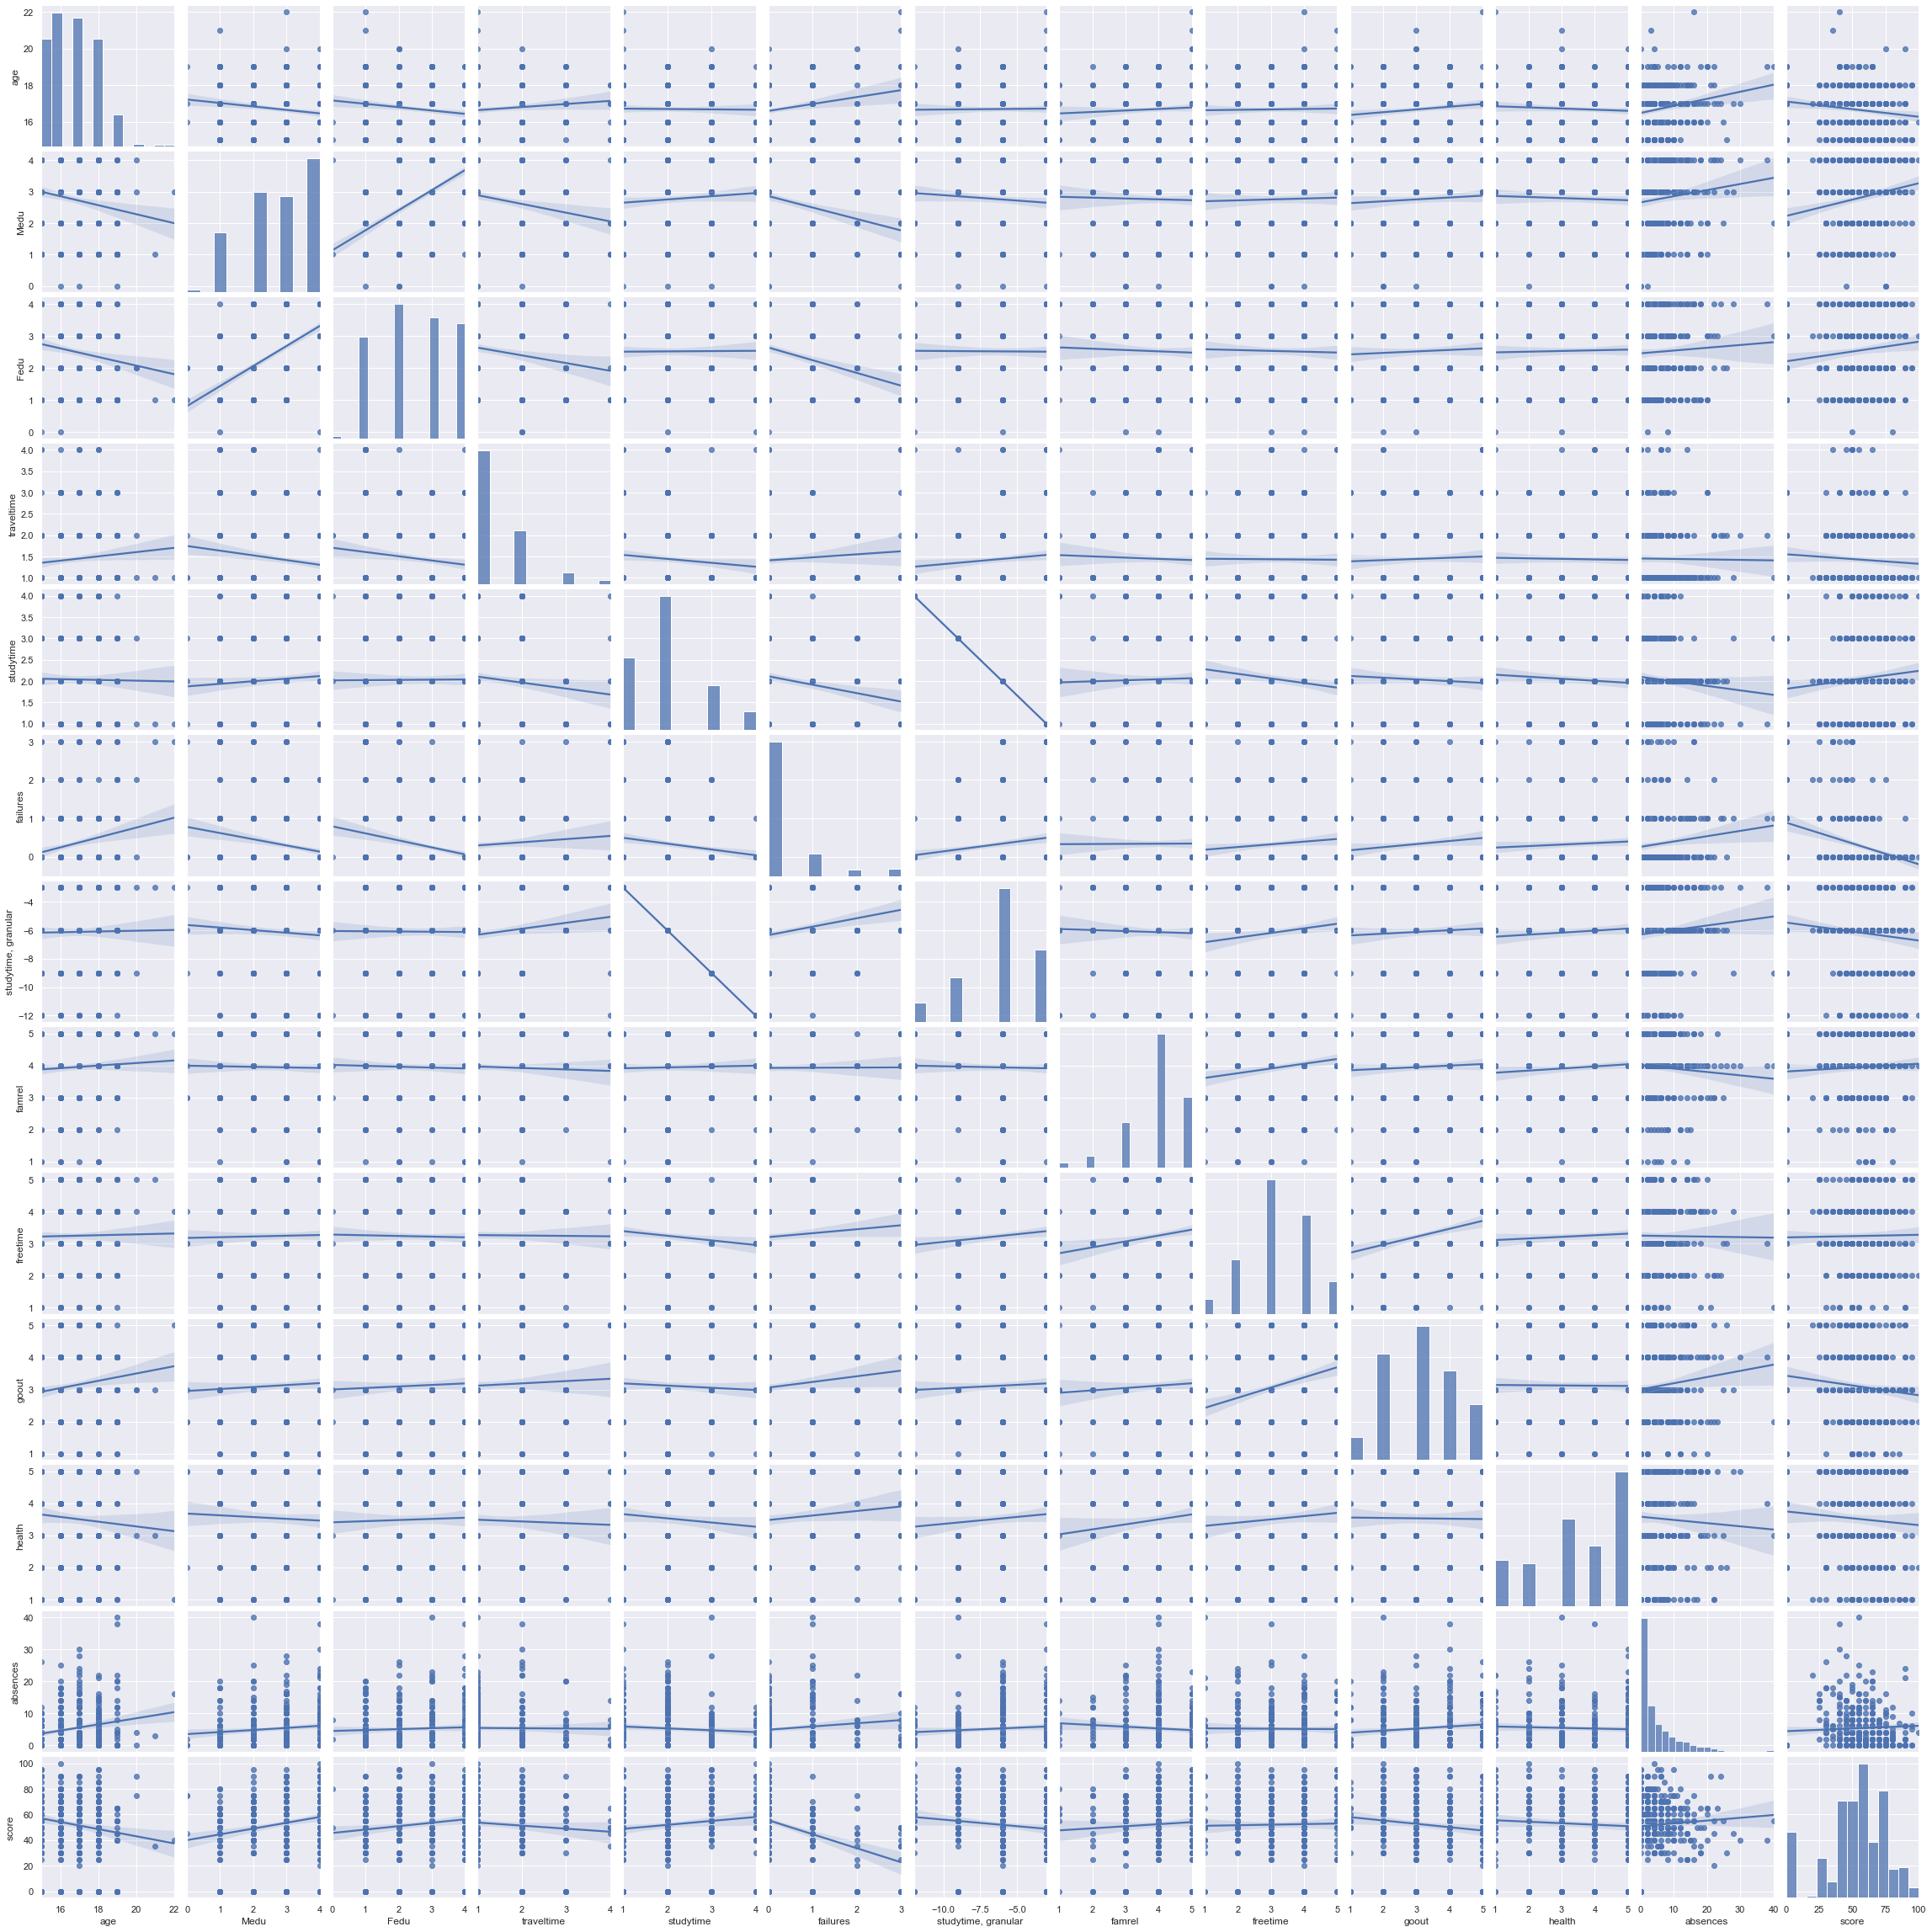

In [11]:
# Построение корреляционной зависимости
sns.pairplot(stud, kind = 'reg')

In [12]:
# Матрица корреляции
stud.corr()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
age,1.000000,-0.164444,-0.156712,0.091718,-0.013277,0.220793,0.013277,0.056953,0.017290,0.130697,-0.067851,0.191796,-0.152513
Medu,-0.164444,1.000000,0.631160,-0.174954,0.078819,-0.242421,-0.078819,-0.021640,0.025534,0.060707,-0.043214,0.111971,0.216809
Fedu,-0.156712,0.631160,1.000000,-0.154587,0.007066,-0.269520,-0.007066,-0.033370,-0.023466,0.047036,0.027678,0.049870,0.127934
traveltime,0.091718,-0.174954,-0.154587,1.000000,-0.113345,0.076689,0.113345,-0.036489,-0.008847,0.044977,-0.026197,-0.010384,-0.072795
studytime,-0.013277,0.078819,0.007066,-0.113345,1.000000,-0.173167,-1.000000,0.025600,-0.124766,-0.052719,-0.078604,-0.078704,0.113930
failures,0.220793,-0.242421,-0.269520,0.076689,-0.173167,1.000000,0.173167,0.004675,0.092961,0.119324,0.074739,0.117607,-0.344656
"studytime, granular",0.013277,-0.078819,-0.007066,0.113345,-1.000000,0.173167,1.000000,-0.025600,0.124766,0.052719,0.078604,0.078704,-0.113930
famrel,0.056953,-0.021640,-0.033370,-0.036489,0.025600,0.004675,-0.025600,1.000000,0.165081,0.059805,0.101054,-0.075355,0.062532
freetime,0.017290,0.025534,-0.023466,-0.008847,-0.124766,0.092961,0.124766,0.165081,1.000000,0.281323,0.071398,-0.009672,0.018950
goout,0.130697,0.060707,0.047036,0.044977,-0.052719,0.119324,0.052719,0.059805,0.281323,1.000000,-0.009593,0.110847,-0.126309


Как было описано выше, признак 'studytime, granular' странный. Также он имеет сильную корреляцию c studytime (пусть и отрицательную) равную -1. Это означает, что этим признаком можно пожертвовать (его можно заменить на studytime). Удаляем..

In [13]:
# Удаляем ненужный столбец
stud.drop('studytime, granular', axis=1, inplace=True)

Будем считать, что если признак имеет корреляцию с итоговой оценкой менее чем 10% (по модулю), то этим признаком можно пренебречь.

В итоге:
* столбцы age, Medu, Fedu, studytime, failures, goout осатются;
* столбцами traveltime, famrel, freetime, health, absences пренебрегаем.

In [14]:
# Удаляем маловлияющие столбцы признаков
stud.drop(['traveltime', 'famrel', 'freetime', 'health', 'absences'], axis = 1, inplace=True)

Как итог: здоровье, время до школы, отношения в семье, пропуски и свободное время не влияют на оценку. Хотя лично я сомневаюсь в пунктах о здоровье и пропусках. Но цифры говорят иначе..

Посмотрим, что получилось снова.

In [15]:
# Выводим информацию о наборе
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 394
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      388 non-null    object 
 1   sex         388 non-null    object 
 2   age         388 non-null    int64  
 3   address     371 non-null    object 
 4   famsize     361 non-null    object 
 5   Pstatus     346 non-null    object 
 6   Medu        385 non-null    float64
 7   Fedu        364 non-null    float64
 8   Mjob        369 non-null    object 
 9   Fjob        352 non-null    object 
 10  reason      371 non-null    object 
 11  guardian    358 non-null    object 
 12  studytime   381 non-null    float64
 13  failures    366 non-null    float64
 14  schoolsup   379 non-null    object 
 15  famsup      351 non-null    object 
 16  paid        348 non-null    object 
 17  activities  374 non-null    object 
 18  nursery     372 non-null    object 
 19  higher      368 non-null    o

# 4. Анализ номинативных переменных
Выполним:
* Проведём анализ распределения рейтинга нечисловых признаков;
* Найдём статистически значимые различия по признакам;
* Удалим всё лишнее.


Распределение баллов по признаку: school


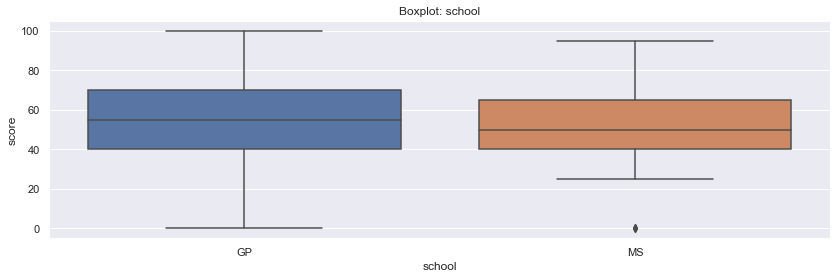

####################################

Распределение баллов по признаку: sex


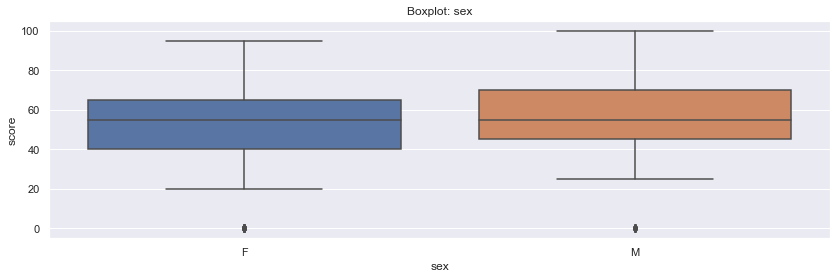

Найдены статистически значимые различия для колонки sex
####################################

Распределение баллов по признаку: address


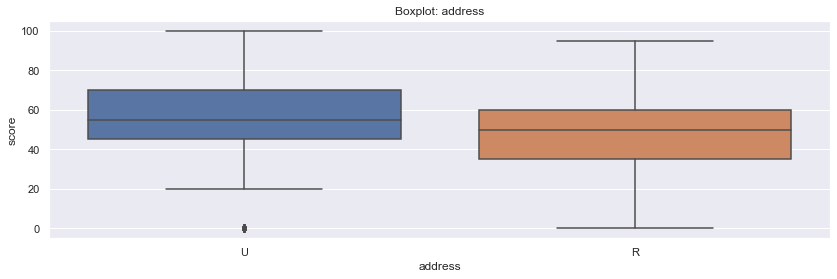

Найдены статистически значимые различия для колонки address
####################################

Распределение баллов по признаку: famsize


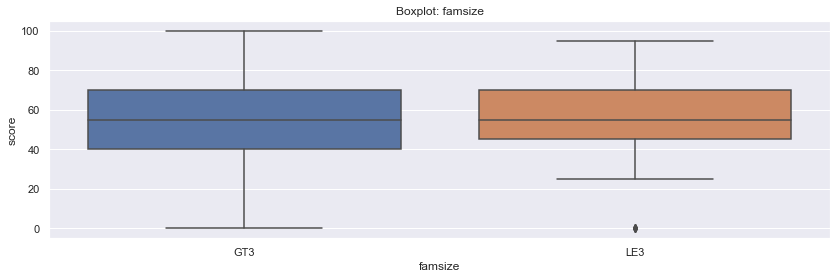

####################################

Распределение баллов по признаку: Pstatus


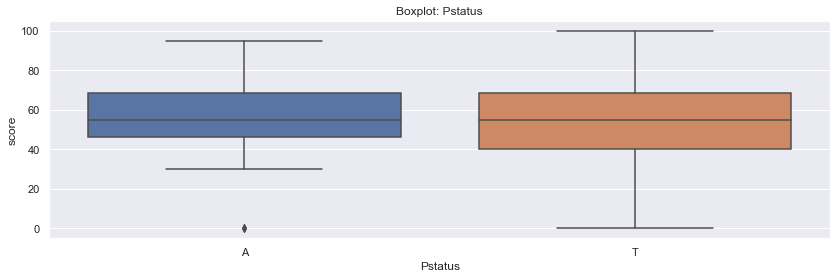

####################################

Распределение баллов по признаку: Mjob


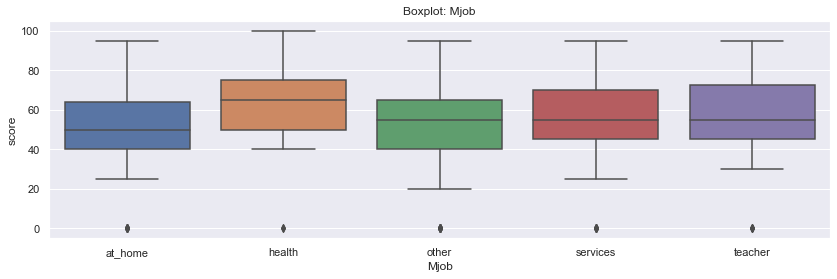

Найдены статистически значимые различия для колонки Mjob
####################################

Распределение баллов по признаку: Fjob


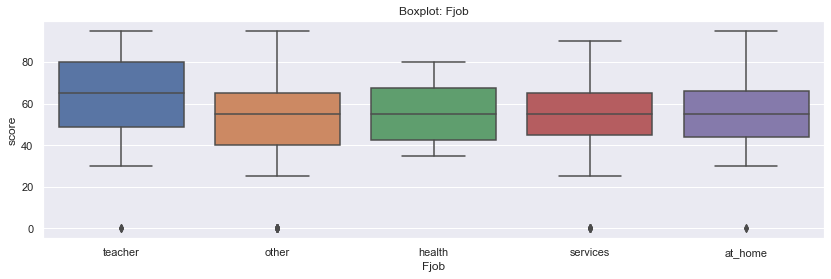

####################################

Распределение баллов по признаку: reason


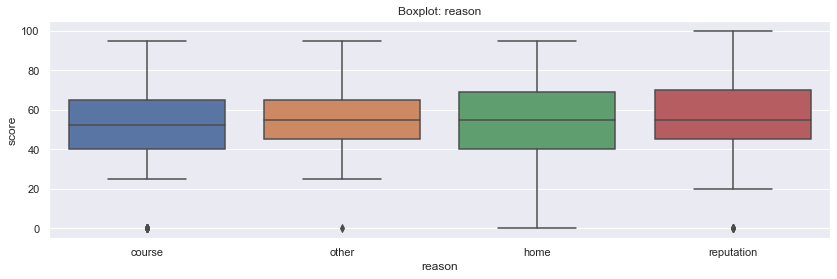

####################################

Распределение баллов по признаку: guardian


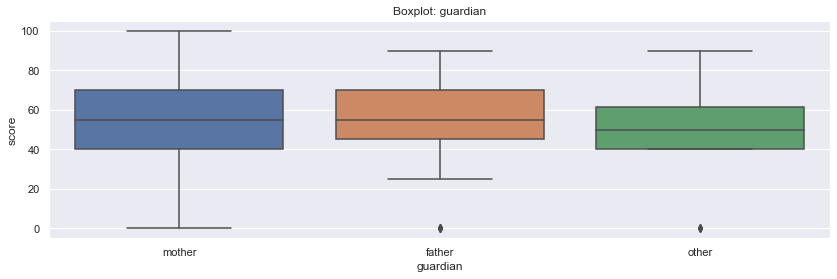

####################################

Распределение баллов по признаку: schoolsup


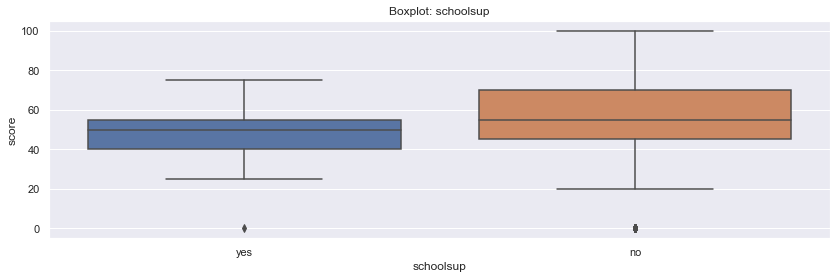

Найдены статистически значимые различия для колонки schoolsup
####################################

Распределение баллов по признаку: famsup


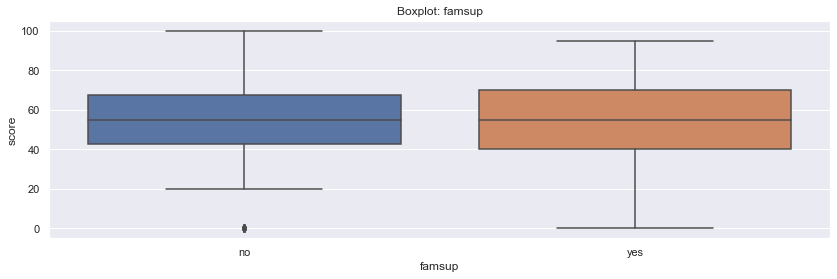

####################################

Распределение баллов по признаку: paid


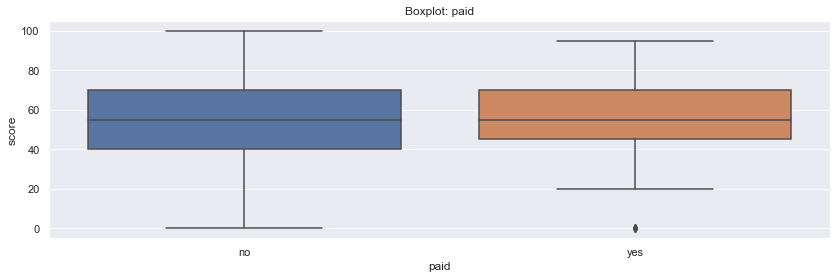

Найдены статистически значимые различия для колонки paid
####################################

Распределение баллов по признаку: activities


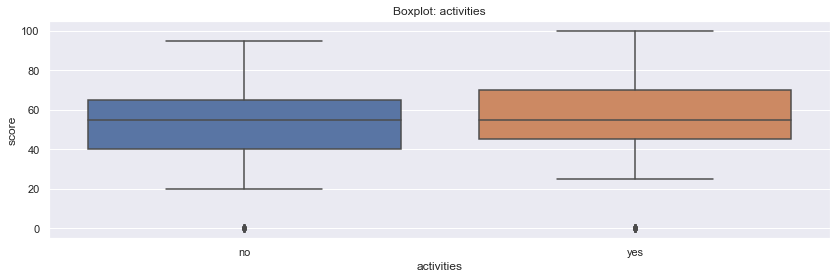

####################################

Распределение баллов по признаку: nursery


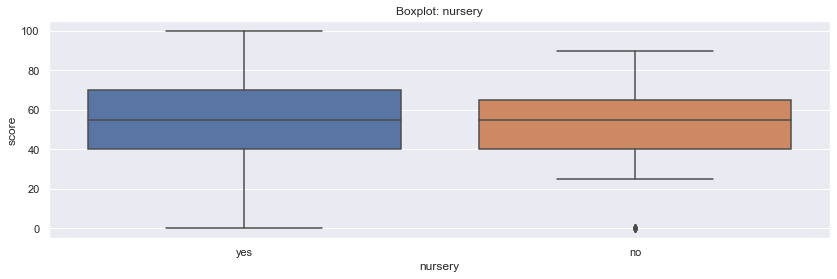

####################################

Распределение баллов по признаку: higher


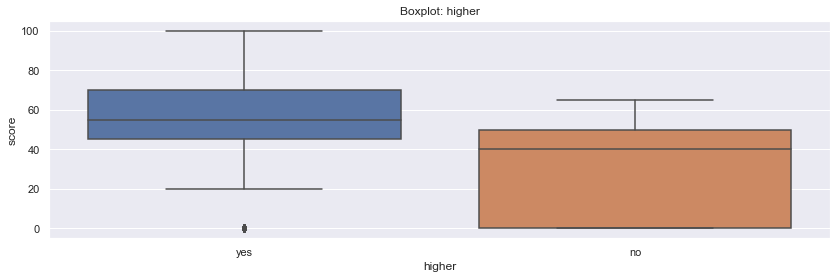

Найдены статистически значимые различия для колонки higher
####################################

Распределение баллов по признаку: internet


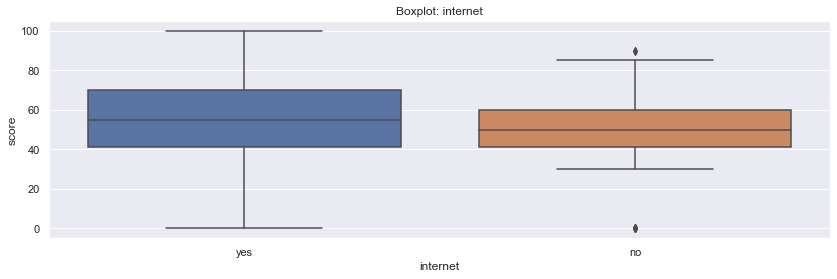

####################################

Распределение баллов по признаку: romantic


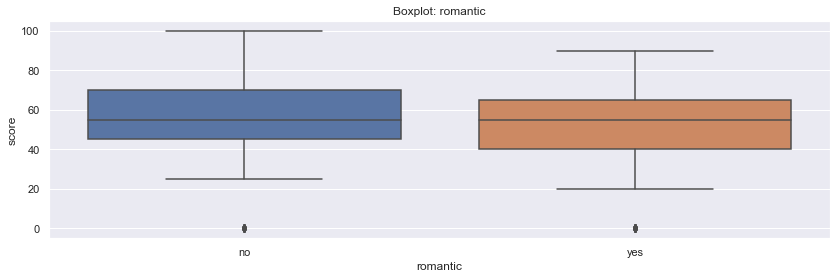

Найдены статистически значимые различия для колонки romantic
####################################



In [16]:
# В цикле выполняем вызов функции pre_analysis
for column in stud.columns:
    nom_analysis(column)

На основе полученных расчётов можно сделать вывод, что столбцы: sex, address, Mjob, schoolsup, paid, higher и romantic важны, так как их распределения различаются. Остальным нечисловыми столбцами пренебрегаем.

In [17]:
# Удаляем ненужное
stud.drop(['school', 'famsize', 'Pstatus', 'Fjob', 'reason',
           'guardian', 'famsup', 'activities', 'nursery',
           'internet'], axis=1, inplace=True)

В итоге: количество членов семьи, их отношения, доступ к интернету и прочее мало влияет на успеваемость. Тем не менее, статистика подтвердила, что матери более тщательно относятся к воспитанию детей, чем отцы, и что мальчики лучше понимают математику, чем девочки. Зато они фору дадут в гуманитарных науках)

In [18]:
# Посмотрим на случайную выборку из 5 учеников
stud.sample(5)

,sex,age,address,Medu,Fedu,Mjob,studytime,failures,schoolsup,paid,higher,romantic,goout,score
307,M,19,U,4.0,4.0,teacher,1.0,1.0,no,yes,yes,yes,4.0,40.0
317,F,18,U,4.0,3.0,other,3.0,0.0,no,yes,yes,yes,4.0,45.0
119,M,15,U,3.0,4.0,other,1.0,0.0,no,no,yes,no,3.0,65.0
116,M,15,U,4.0,4.0,other,2.0,0.0,no,no,yes,no,3.0,70.0
253,M,16,R,2.0,1.0,other,1.0,0.0,no,NaN,yes,no,2.0,40.0


In [19]:
# Окончательная сводная информация
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 394
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sex        388 non-null    object 
 1   age        388 non-null    int64  
 2   address    371 non-null    object 
 3   Medu       385 non-null    float64
 4   Fedu       364 non-null    float64
 5   Mjob       369 non-null    object 
 6   studytime  381 non-null    float64
 7   failures   366 non-null    float64
 8   schoolsup  379 non-null    object 
 9   paid       348 non-null    object 
 10  higher     368 non-null    object 
 11  romantic   357 non-null    object 
 12  goout      380 non-null    float64
 13  score      382 non-null    float64
dtypes: float64(6), int64(1), object(7)
memory usage: 55.5+ KB


# 5. Выводы


* В подавляющем большинстве колонок есть пропуски (в пределах 12%), кроме признаков school, sex, age. Как восполнить недостающую информацию на данный момент непонятно; 
* В наборе для признаков Fedu, famrel присутствуют выбросы (данные не соответствовали постановке). Возможная причина - порча набора, либо что-то другое;
* В столбце absences также есть выбросы. По их распределению сложно сказать, что причина. Либо просто ученик болел, либо попал в какую-то сложную ситуацию, так как встречались значения, которые соответствовали отсутствию более полугода. Либо это снова порча данных, либо некорректно заполненная информация;
* В наборе присутствует столбец studytime, granular, который по сути дублирует признак studytime;
* На оценку ЕГЭ не влияют (не коррелируют): здоровье, время в пути до школы, отношения в семье, количество свободного времени, работа отца (в отличие от матери) и даже пропуски, что удивительно. 
* На оценку влияют такие признаки как: пол, место жительства, работа матери, дополнительная образовательная поддержка, дополнительные занятия, желание получить высшее образование, наличие влюблённости (вот тут я не удивлён),возраст, образование матери, отца, сколько времени уделяется на учёбу вне школы, ошибки и времяпрепровождение с друзьями. 
* В дальнейшем без потери общности можно использовать обновленный набор.
